<a href="https://colab.research.google.com/github/Loumstar/Improving-RoBERTa/blob/master/main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!nvidia-smi

Thu Mar  3 14:21:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |  10836MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup


## Installations & Imports

In [61]:
!pip install transformers sentencepiece ipywidgets tensorboardx wandb
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [62]:
import logging
import string
import wandb
import nltk
import torch

import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from urllib import request

from transformers import Trainer, TrainingArguments
from transformers import DebertaTokenizer, DebertaForSequenceClassification

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

from torch.utils.data import DataLoader

if not torch.cuda.is_available():
  print('WARNING: You may want to change the runtime to GPU for faster training!')
  DEVICE = 'cpu'
else:
  print("CUDA available.")
  DEVICE = 'cuda:0'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CUDA available.


## Mount Google Drive

In [63]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/'
%mkdir './nlp-cswrk'
%cd './nlp-cswrk' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘./nlp-cswrk’: File exists
/content/drive/MyDrive/nlp-cswrk


## Logging

In [64]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

## Download Datasets

In [65]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/train_semeval_parids-labels.csv


In [66]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/practice%20splits/dev_semeval_parids-labels.csv


In [67]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [68]:
from dont_patronize_me import DontPatronizeMe

dpm = DontPatronizeMe('.', '.')
dpm.load_task1()

In [69]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Pre-processing

## Data Formatting

### Convert CSVs to Data Frames

In [70]:
train_import = pd.read_csv('train_semeval_parids-labels.csv')
test_import = pd.read_csv('dev_semeval_parids-labels.csv')

In [71]:
train_import.par_id = train_import.par_id.astype(str)
test_import.par_id = test_import.par_id.astype(str)

In [72]:
rows = [] # will contain par_id, label and text
for idx in range(len(train_import)):
  parid = train_import.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
train_df = pd.DataFrame(rows)

In [73]:
rows = [] # will contain par_id, label and text
for idx in range(len(test_import)):  
  parid = test_import.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
  country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
  intensity = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
  length = len(dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0])
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label,
      'keyword':keyword,
      'country':country,
      'intensity':intensity,
      'length':length
  })
  test_df = pd.DataFrame(rows)

### Shuffle Datasets

In [74]:
train_df = shuffle(train_df)

train_df, val_df = train_test_split(train_df, train_size=0.8)

test_df = shuffle(test_df)

## Implementations

### Main Function
Enter iteration number to pre-process data corresponding to the implementation iteration.

In [77]:
def main_implement(implementation_number, train):
    if implementation_number == 1:
        train = downsample_unpat(train)
    elif implementation_number == 2:
        train = downsample_unpat(train)
        train = upsample_pat(train)
    elif implementation_number == 3:
        train = downsample_unpat(train)
        train = lemmatise_df(train)
    elif implementation_number == 4:
        train = add_backtranslations(train)
        train = downsample_unpat(train)
    train.length = train.text.str.split().map(get_list_length)
    return train

In [78]:
def get_list_length(x):
  if type(x) == list:
    return len(x)
  elif x is not None:
    return 1
  else:
    return None

In [79]:
def get_label_ratio(dataset):
    return len(dataset[dataset.label == 0])/len(dataset[dataset.label == 1])

### Implementation 1
Downsample unpatronising data (as in competition's roberta base) (ratio from 9:1 to 3:1).

In [80]:
def downsample_unpat(train):
    pat_train = train[train.label == 1]
    npos = len(pat_train)

    train = pd.concat([pat_train,train[train.label == 0][:npos*3]])
    return train

### Implementation 2
Upsample patronising data

In [81]:
def upsample_pat(train):
    ratio = int(get_label_ratio(train))

    pat_train = train[train.label == 1]
    unpat_train = train[train.label == 0]

    pat_train = pd.concat([pat_train]*ratio)
    train = pd.concat([pat_train, unpat_train])
    
    return train

In [82]:
def df_to_dict_of_lists(df):
    texts = df['text'].values.tolist()
    labels = df['label'].values.tolist()
    parids = df['par_id'].values.tolist()
    keywords = df['keyword'].values.tolist()
    countries = df['country'].values.tolist()
    intensities = df['intensity'].values.tolist()
    lengths = df['length'].values.tolist()
    
    return {
        'texts': texts,
        'labels': labels,
        'parids': parids,
        'keywords': keywords,
        'countries': countries,
        'intensities': intensities,
        'lengths': lengths
    }

### Implementation 3
Lemmatise words in text using verb PoS tagging

In [83]:
lemmatizer = WordNetLemmatizer()

def remove_punctuation(token):
    return not any(map(lambda s: s in string.punctuation, token))

def lemmatise(word):
    return lemmatizer.lemmatize(word, pos="v")

def lemmatise_sentence(sentence):
  tokens = wordpunct_tokenize(sentence)
  tokens = list(map(lemmatise, tokens))
  # tokens = list(filter(remove_punctuation, tokens))

  return " ".join(tokens)

def lemmatise_df(df):
  df.text = df.text.map(lemmatise_sentence)
  
  return df

### Implementation 4
Generate new examples using back-translation (of French and Spanish)



In [84]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_french_backtranslation.csv


In [85]:
module_url = f"https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv" 
module_name = module_url.split('/')[-1]

print(f'Fetching {module_url}')
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  b = f.read()
  outf.write(b.decode('latin-1'))

Fetching https://raw.githubusercontent.com/Loumstar/Improving-RoBERTa/master/data/dontpatronizeme_spanish_backtranslation.csv


In [86]:
backtranslated_cols = ["par_id", "art_id", "category", "country", "text", "score"]

french_import = pd.read_csv('dontpatronizeme_french_backtranslation.csv', names=backtranslated_cols)
spanish_import = pd.read_csv('dontpatronizeme_spanish_backtranslation.csv', names=backtranslated_cols)

In [87]:
# Copy the training dataset and swap out the text 
# for the back-translated version.
french_df = train_df.copy()
french_df.text = french_import.text

spanish_df = train_df.copy()
spanish_df.text = spanish_import.text

def add_backtranslations(df):
  df = df.append(french_df, ignore_index=True, 
                 verify_integrity=True)
  
  df = df.append(spanish_df, ignore_index=True, 
                 verify_integrity=True)
  
  df.length = df.text.str.split().map(get_list_length)
  df.dropna(inplace=True)
  
  return df

### Choose Implementation

In [89]:
train_df = main_implement(3, train_df)

In [90]:
print(get_label_ratio(train_df))

3.0


In [91]:
train_df

,par_id,text,label,keyword,country,intensity,length
501,8340,Sr Luise earn the trust of development partner...,1,refugee,ke,2,50
342,1273,The come fury of angry America be as palpable ...,1,hopeless,in,3,57
532,3357,The former Jewish neighbourhood in the city of...,1,poor-families,gb,3,47
6,6027,"As a member of Care of Hope , Barnett provide ...",1,homeless,jm,4,59
786,6552,"""-- In 2014 Make the Future showcased Pavegen ...",1,in-need,ng,2,121
...,...,...,...,...,...,...,...
3830,3369,A team of experts across several discipline at...,0,women,ph,0,100
2625,2046,San Francisco be currently face a hard time wi...,0,homeless,lk,0,43
3949,3501,""""""" My parent use to say , always help people ...",0,in-need,ph,1,45
2907,2353,Market confidence be a hopelessly fragile sens...,0,hopeless,au,0,44


## More Data Formatting

Convert data to class and create embeddings from tokeniser

In [92]:
class PatroDataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, input_set, max_length=128):

        self.tokenizer = tokenizer
        self.texts = input_set['texts']
        self.labels = input_set['labels']
        self.parids = input_set['parids']
        self.keywords = input_set['keywords']
        self.countries = input_set['countries']
        self.intensities = input_set['intensities']
        self.lengths = input_set['lengths']

        self.max_length = max_length

    def collate_fn(self, batch):
        texts, labels = [], []

        for b in batch:
            texts.append(b['text'])
            labels.append(b['label'])

        encodings = self.tokenizer(texts, return_tensors='pt', 
                                   padding=True, truncation=True, 
                                   max_length=self.max_length)
        
        encodings['label'] =  torch.tensor(labels)
        
        return encodings
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
       
        return {
            'text': self.texts[idx],
            'label': self.labels[idx],
            'parid': self.parids[idx],
            'keyword': self.keywords[idx],
            'countriy': self.countries[idx],
            'intensity': self.intensities[idx],
            'length': self.lengths[idx]
        }

In [93]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

In [94]:
trainset = df_to_dict_of_lists(train_df)
valset = df_to_dict_of_lists(val_df)
testset = df_to_dict_of_lists(test_df)

val_dataset = PatroDataset(tokenizer, testset)
test_dataset = PatroDataset(tokenizer, testset)

## Model

##### Hyperparameter Tuning

In [95]:
hyperparameter_tuning = True

if hyperparameter_tuning:
    wandb.login()

    config = {
        "name": "vanilla-sweep",
        "method": "grid",
        "metric": {
            "name": "f1_score",
            "goal": "maximize"
        },
        "parameters": {
            "num_epochs": {
                "values":[3, 4, 5]
            },
            "learning_rate": {
                "values":[1e-4, 1.5e-4, 2e-4]
            },
            "max_length": {
                "values": [64, 128, 256]
            }
        },
        "early_terminate": {"type": "hyperband", "min_iter": 3},
    }

    sweep_id = wandb.sweep(config, project="DeBERTa Hyperparameter Tuning")

Create sweep with ID: lpokxkkx
Sweep URL: https://wandb.ai/matthewcollins/DeBERTa%20Hyperparameter%20Tuning/sweeps/lpokxkkx


DeBERTa Implementation and Training

In [96]:
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")

#180 M
print(f"Model size: {model.num_parameters()}")

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'pooler.d

Model size: 139193858


In [97]:
class Trainer_patronise(Trainer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.losses = []

    def compute_loss(self, model, inputs):
        labels = inputs.pop('label')

        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_task = nn.CrossEntropyLoss()

        loss = loss_task(logits, labels)
        self.losses.append(loss.item())
        
        return loss

In [98]:
def main_patronise():
    if hyperparameter_tuning:
        wandb.init()
        learning_rate = wandb.config.learning_rate
        max_length = wandb.config.max_length
        num_epochs = wandb.config.num_epochs
    else:
        learning_rate = 0.0001
        max_length = 128
        num_epochs = 4

    train_dataset = PatroDataset(tokenizer, trainset,
                                 max_length=max_length)
    
    val_loader = DataLoader(val_dataset)

    #call our custom BERT model and pass as parameter the name of an available pretrained model
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base")
    
    training_args = TrainingArguments(
        output_dir='./',
        learning_rate=learning_rate,
        lr_scheduler_type='linear',
        logging_steps=100,
        per_device_train_batch_size=32,
        num_train_epochs=num_epochs,
        adam_beta1 = 0.9,
        adam_beta2 = 0.999,
        adam_epsilon = 1e-6,
        max_grad_norm = 1.0,
        save_steps = 2500
    )
    trainer = Trainer_patronise(
        model=model,              
        args=training_args,                
        train_dataset=train_dataset,          
        data_collator=train_dataset.collate_fn
    )
    
    trainer.train()
    trainer.save_model('./')

    report, _ = evaluate(model, tokenizer, val_loader, val_df)
    f1_score = report[1]["f1-score"]

    if hyperparameter_tuning:
        wandb.log({"f1_score": f1_score})  
        wandb.join()

    return trainer.losses

# EVALUATION

## Hyper-parameter Training

In [101]:
def predict_patronise(input, tokenizer, model): 
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=128)
  
  output = model(**encodings)
  preds = torch.max(output.logits, 1)

  return {'prediction':preds[1], 'confidence':preds[0]}

In [102]:
def evaluate(model, tokenizer, data_loader, test_df):

  total_count = 0
  correct_count = 0 

  preds = []
  tot_labels = []

  test_df['prediction'] = np.nan

  with torch.no_grad():
    for data in tqdm(data_loader):
      labels = {}
      labels['label'] = data['label']

      sentences = data['text']

      pred = predict_patronise(sentences, tokenizer, model)

      preds.append(pred['prediction'].tolist())
      tot_labels.append(labels['label'].tolist())

      for id, data_prediction in zip(data['parid'], pred['prediction']):
        rows = test_df.loc[test_df.par_id == id]
        rows.prediction = data_prediction.tolist()
        test_df.update(rows)

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)

  return report, test_df

In [ ]:
if hyperparameter_tuning:
    losses = wandb.agent(sweep_id, function=main_patronise, count=10)
else:
    losses = main_patronise()

wandb: Agent Starting Run: yf47dqvs with config:
wandb: 	learning_rate: 0.0001
wandb: 	max_length: 64
wandb: 	num_epochs: 5


loading configuration file https://huggingface.co/microsoft/deberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e313266bff73867debdfa78c78a9a4966d5e78281ac4ed7048c178b16a37eba7.fb501413b9cef9cef6babdc543bb4153cbec58d52bce077647efba3e3f14ccf3
Model config DebertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "c2p",
    "p2c"
  ],
  "position_biased_input": false,
  "relative_attention": true,
  "transformers_version": "4.16.2",
  "type_vocab_size": 0,
  "vocab_size": 50265
}

loading weights file https://huggingface.co

Step,Training Loss
100,0.484800


## Final Model

DEFINE HYPER-PARAMETERS AND RUN MODEL ON WHOLE TRAINING SET

ValueError: ignored

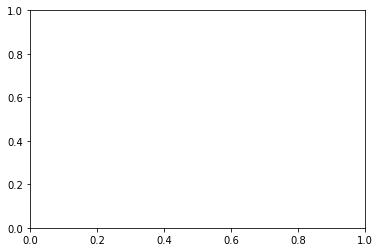

In [100]:
plt.plot(losses)

In [ ]:
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#your saved model name here
model_name = './'
model = DebertaForSequenceClassification.from_pretrained(model_name)

# we don't batch our test set unless it's too big
test_loader = DataLoader(test_dataset)

report, annotated_test_dataset = evaluate(model, tokenizer, test_loader, test_df)

print(report)

print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

In [ ]:
annotated_test_dataset[annotated_test_dataset.prediction==1]

In [ ]:
def analysis_on_intensities(annotated_dataset):
    scores = []
    for intensity_value in range(0,5):
        subset_dataset = annotated_dataset.loc[annotated_dataset.intensity.map(int) == intensity_value]
        labels = subset_dataset['label'].tolist()
        preds = subset_dataset['prediction'].tolist()
        score = f1_score(labels, preds)
        print(score)
        scores.append(score)
    return scores

In [ ]:
analysis_on_intensities(annotated_test_dataset)

In [ ]:
def analysis_on_input_size(annotated_dataset):
    for i in range(0,6):
        subset_dataset = annotated_dataset.loc[i*50 <= annotated_dataset.length.map(int) < (i+1)*50]
        


    plt.title("Average Character Length of a sample")
    plt.ylabel("Frequency")
    plt.xlabel("Character Length")

    # series = df["text"].str.len()

    # print(series.max())
    # series.hist(bins=200, figsize=(8, 6))

    # unpatronising_df["text"].str.len().hist(bins=200, alpha=0.5, figsize=(8, 6))
    # patronising_df["text"].str.len().hist(bins=200, alpha=0.5, figsize=(8, 6))

    (unpatcounts, unpatbins) = np.histogram(unpatronising_df["text"].str.len(), bins=100, range=(0, 2000))
    (patcounts, patbins) = np.histogram(patronising_df["text"].str.len(), bins=100, range=(0, 2000))

    factor = 1/len(unpatronising_df["text"])
    plt.hist(unpatbins[:-1], unpatbins, weights=factor*unpatcounts, alpha=0.6)

    factor = 1/len(patronising_df["text"])
    plt.hist(patbins[:-1], patbins, weights=factor*patcounts, alpha=0.6)

    plt.xlim((0, 2000))

In [ ]:
print(report['accuracy'])
print(report[0]['f1-score'])
print(report[1]['f1-score'])

In [ ]:

report = classification_report(tot_labels, preds, target_names=[0,1], output_dict= True)
